In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from vpolo.alevin import parser

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../salmon_brain2k_out/brain2k.h5ad'
sc.settings.set_figure_params(dpi=80)

mydata = parser.read_quants_bin("/home/fgao/Data_single_cell/kallisto_benchmark/salmon_brain2k_out/")
mydata_t = mydata.T
mydata_t.to_csv('../salmon_brain2k_out/brain2k.csv', sep=',')

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
/home/fgao/Data_single_cell/kallisto_benchmark/salmon_brain2k_out/alevin
 Done reading 2800 cells
Read total 2876 cells
Found total 3829995.0 reads


In [2]:
data = pd.read_csv('../salmon_brain2k_out/brain2k.csv', index_col=0)
data.index = [i[0] for i in data.index.str.split(".")]
gene = pd.read_table('../10XGv2_brain2k_out/outs/raw_gene_bc_matrices/mouse_10XGv2_primary/genes.tsv', index_col=0, header=None)
mydata_symbol = pd.merge(gene, data, left_index=True, right_index=True)
mydata_symbol.index=mydata_symbol[1]
mydata_symbol2=mydata_symbol.drop([1],axis=1)
mydata_symbol2
mydata_symbol2.T.to_csv('../salmon_brain2k_out/brain2k_symbol.csv', sep=',')

In [3]:
adata = sc.read_csv('../salmon_brain2k_out/brain2k_symbol.csv')
adata.var_names_make_unique()
#gene_ids = pd.read_csv('../salmon_brain2k_out/alevin/quants_mat_cols.txt')
#bc = pd.read_csv('../salmon_brain2k_out/alevin/quants_mat_rows.txt')
#mart = pd.read_table('../index/mart_export_mouse.txt', index_col=0)



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)
mito_genes = [name for name in adata.var.index if name.startswith('mt-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

filtered out 274 cells that have less than 100 genes expressed
filtered out 16806 genes that are detected in less than 2 cells


In [5]:
adata

AnnData object with n_obs × n_vars = 2602 × 18320 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [6]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 1561 × 18320 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [8]:
sc.pp.log1p(adata)
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

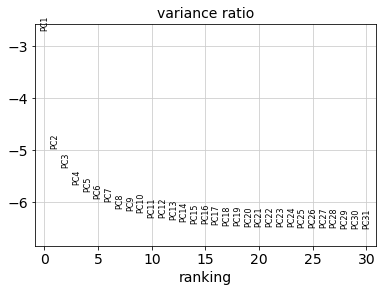

In [9]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:08.14) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:04.32) --> added
    'X_umap', UMAP coordinates (adata.obsm)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.06) --> found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


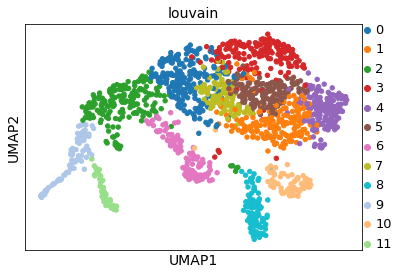

In [11]:
sc.tl.louvain(adata, resolution=1.1)
sc.pl.umap(adata, color=['louvain'])

computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:45.57) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


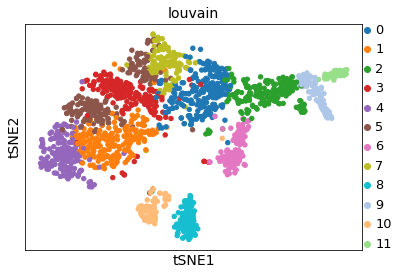

In [12]:
sc.tl.tsne(adata, n_pcs=20)
sc.pl.tsne(adata, color=['louvain'])

In [13]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test', corr_method='benjamini-hochberg')

ranking genes
    finished (0:00:01.14) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [14]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
#pd.DataFrame({group + '_' + key: result[key][group]
#    for group in groups for key in ['names', 'scores','logfoldchanges','pvals','pvals_adj']}).head(20)

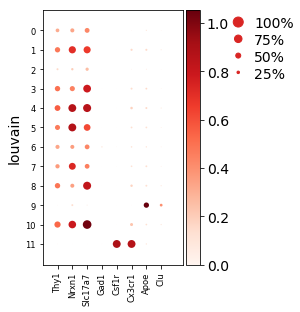

In [15]:
marker_genes = ['Thy1','Nrxn1','Slc17a7','Gad1','Csf1r','Cx3cr1','Apoe','Clu']
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

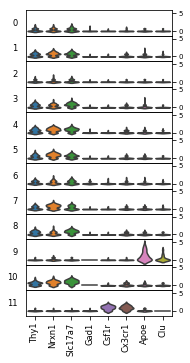

In [16]:
sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)